<a href="https://colab.research.google.com/github/dedeazzo/Image-Captioning-with-GRU/blob/main/Image_Captioning_with_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Captioning


In this notebook, an image captioning algorithm is developed by merging CNN and RNN networks.

### Library and Parameters

In [ ]:
import re
import os
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.applications.efficientnet_v2 import EfficientNetV2B3, preprocess_input
from tensorflow import keras, expand_dims, reduce_mean, reshape, io
from tensorflow.nn import sparse_softmax_cross_entropy_with_logits
from tensorflow.data import Dataset, AUTOTUNE
from tensorflow.compat import as_str_any
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, GRU, TextVectorization, StringLookup, Resizing
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# >>> Parameters <<<
load = False
save = True
random_state  = 2022
epochs        = 20
val_size      = 0.2
batch_size    = 64
buffer_size   = 500
max_sent_len  = 30
vocab_len     = 5000
embedding_dim = 256 
hidden_units  = 512
encoder_dim   = 1536
dropout_size  = 0.5
learning_rate = 0.001
es_patience   = 3
rlr_patience  = 5
curr_wd       = '/content/drive/MyDrive/ML3'
model_name    = 'gru_captioning_model.h5'

In [ ]:
# connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir(curr_wd)
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/ML3


### Selected dataset

We will use Flickr8k dataset. Here is a description from Kaggle (https://www.kaggle.com/adityajn105/flickr8k):

A new benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The images were chosen from six different Flickr groups, and tend not to contain any well-known people or locations, but were manually selected to depict a variety of scenes and situations.

In [ ]:
# FLICKR8K
DATA_CAP_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip'
DATA_IMG_ORIGIN = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip'

# DATA SAVE FOLDERS
CAP_FOLDER = '/'
IMG_FOLDER = '/Flicker8k_Dataset/'

### Preprocessing

We will download the dataset from the repository and make it ready to be put into the model. For captions, preprocessing techniques including tokenization and padding will be needed. 

In [ ]:
def download_images():
  # Download caption annotation files
  cap_zip = tf.keras.utils.get_file('Flickr8k_text.zip',
                                        cache_subdir = os.path.abspath('.'),
                                        origin = DATA_CAP_ORIGIN,
                                        extract = True)
  caption_path = os.path.dirname(cap_zip)+CAP_FOLDER+'Flickr8k.token.txt'

  #REMOVE ZIP
  os.remove(cap_zip)
    
  if not os.path.exists(os.path.abspath('.') + IMG_FOLDER):
    image_zip = tf.keras.utils.get_file('Flickr8k_Dataset.zip',
                                        cache_subdir=os.path.abspath('.'),
                                        origin = DATA_IMG_ORIGIN,
                                        extract = True)
    image_path = os.path.dirname(image_zip) + IMG_FOLDER
    
    #REMOVE ZIP
    os.remove(image_zip)

  else:
    image_path = os.path.abspath('.') + IMG_FOLDER

  img_lists = []

  # load image lists
  for imgfile in os.listdir(image_path):
    filename = os.fsdecode(imgfile)
    img_lists.append(image_path+filename)

  return caption_path, image_path, img_lists

This block will save the locations of the images and captions.

In [ ]:
caption_path, image_path, img_lists = download_images()

2351104/2340801 [==============================] - 1s 0us/step


In [ ]:
caption_path

'/content/drive/MyDrive/ML3/Flickr8k.token.txt'

In [ ]:
image_path

'/content/drive/MyDrive/ML3/Flicker8k_Dataset/'

In [ ]:
img_lists[1]

'/content/drive/MyDrive/ML3/Flicker8k_Dataset/379006645_b9a2886b51.jpg'

Dataset Example

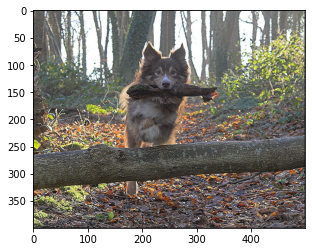

In [ ]:
img = mpimg.imread(img_lists[0])
imgplot = plt.imshow(img)
plt.show()

The caption file has both filenames and captions. Processing is done to have pure captions and the same indices as the images.

In [ ]:
# open Flickr8k.token.txt and read
with open(caption_path) as f:
    lines = f.readlines()
print(lines[0])

captions_dict = {}

# create a dictionary with image path as key and list of corresponding captions as values
for l in lines:
    # convert captions to lowercase, remove punctuation, remove double spaces, add start/end tokens
    tmp_capt = re.sub(' {2,}', ' ', '<start> ' + ((l.split('\t')[1].split('\n')[0]).lower()).translate(str.maketrans('', '', string.punctuation)) + ' <end>')
    captions_dict.setdefault(image_path + l.split('#')[0], []).append(tmp_capt)


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .



### Architectures

The first action might be to generate a CNN (our encoder). This wiil be done using a pretrained architecture, since it is hard to train this massive model without good physical machines. After that, we will use the last pooling layer of the architecture without the output layer and link it to an embedded vector.

- When using a pretrained model, the data is transformed using the same pre-processing techniques. 

For the decoder, a Gated Recurrent Unit (GRU) RNN-based architectures.

1. Dataset split 

In [ ]:
y = []

# create 2D array of captions corresponding to image paths list
for path in img_lists:
    y.append(captions_dict.get(path))

# split into train and validation sets with 80% training set
X_train, X_val, y_train, y_val = train_test_split(img_lists, y, test_size=val_size, random_state=random_state)

2. Call pretrained CNN model and set it up.
 - Output layer of the pretrained model is removed
 - Dataset is preprocessed using the preprocessing method in the pretrained model.
 - Finally dataset is shuffled, batched, and prefetched.

In [ ]:
# initialize base CNN model with pre-trained weights and remove output layer
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet_v2/EfficientNetV2B3
model_pretrained = EfficientNetV2B3(include_top=False, weights='imagenet', pooling='avg')
model_pretrained = Model(model_pretrained.input, model_pretrained.layers[-1].output)


52617216/52606240 [==============================] - 1s 0us/step


In [ ]:
# https://www.tensorflow.org/tutorials/text/image_captioning#preprocess_and_tokenize_the_captions

# initialize text vectorization layer
text_vector_layer = TextVectorization(max_tokens=vocab_len, standardize=None, output_sequence_length=max_sent_len)

# flatten 2D caption list and adapt tokenizer
text_vector_layer.adapt([_ for i in range(len(y)) for _ in y[i]])

# adapt text vectorization word mappings for words to vectors and vice versa
word_indexing = StringLookup(vocabulary=text_vector_layer.get_vocabulary(), mask_token="")
index_wording = StringLookup(vocabulary=text_vector_layer.get_vocabulary(), mask_token="", invert=True)


In [ ]:
# load file (for image and caption data)
def load_file(file_name):

    temp_array = []

    try:
        with open(file_name, "rb") as f:
            temp_array = pickle.load(f)
        print(file_name, 'File Loaded')
    except Exception as e:
        print('Error Loading File for ', file_name)

    return temp_array


# save file (for image and caption data)
def save_file(file_name, temp_array):

    try: 
        with open(file_name, "wb") as f:
            pickle.dump(temp_array, f)
        print(file_name, 'File Saved')
    except Exception as e:
        print('Error Saving File for ', file_name)


In [ ]:
# create tensor dataset for given image and caption data
def create_tensor_dataset(X, y, file_name='', batch_size=16, buffer_size=200, save_data=False, load_data=False):
    
    img_vec = []
    txt_src = []
    txt_trg = []

    # load image and caption files
    if load_data:
        img_vec = load_file(file_name + "_img_vec")
        txt_src = load_file(file_name + "_txt_src")
        txt_trg = load_file(file_name + "_txt_trg")
    
    else:
        for i in tqdm(range(len(X))):
            # load and reshape image, convert to array and expand for batching, preprocess and predict with EfficientNetV2B3, and remove extra dimensions
            vector = np.squeeze(model_pretrained.predict(preprocess_input(expand_dims(Resizing(286, 286)(io.decode_jpeg(io.read_file(X[i]), channels=3)), axis = 0))))
            # create a seperate entry for each tokenized caption with its corresponding vectorized image
            # (this was done after splitting the data so that images in the training set don't appear in the validation set)
            for caption in y[i]:
                img_vec.append(vector)
                # <end> tag is removed from input caption and <start> tag removed from label caption
                txt_src.append(text_vector_layer(caption.rsplit(' ', 1)[0]))
                txt_trg.append(text_vector_layer(caption.split(' ', 1)[1]))
        
        # save image and caption files
        if save_data:
            save_file(file_name + "_img_vec", img_vec)
            save_file(file_name + "_txt_src", txt_src)
            save_file(file_name + "_txt_trg", txt_trg)  

    # convert data with keys to tf.data format and return shuffled, batched and prefetched data
    return (Dataset.from_tensor_slices(({'encoder_in': img_vec, 'decoder_in': txt_src}, {'decoder_out_l2': txt_trg})).shuffle(buffer_size, seed=random_state).batch(batch_size)).prefetch(buffer_size=AUTOTUNE)


In [ ]:
# preprocess training and validation data
train_data = create_tensor_dataset(X_train, y_train, 'train', batch_size, buffer_size, save_data=save, load_data=load)
val_data = create_tensor_dataset(X_val, y_val, 'val', batch_size, buffer_size, save_data=save, load_data=load)

100%|██████████| 6472/6472 [18:37<00:00,  5.79it/s]


train_img_vec File Saved
train_txt_src File Saved
train_txt_trg File Saved


100%|██████████| 1619/1619 [04:03<00:00,  6.64it/s]


val_img_vec File Saved
val_txt_src File Saved
val_txt_trg File Saved


3. Encoder-Decoder Structure
 - Encoder: Last hidden layer of the pretrained model is connected to one FCN of a defined size.
 - Decoder: The encoded values (from FCN) are linked to the RNN network and the model is developed further with a few more fully connected networks.

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_in (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 encoder_in (InputLayer)        [(None, 1536)]       0           []                               
                                                                                                  
 decoder_l1 (Embedding)         (None, None, 256)    1280000     ['decoder_in[0][0]']             
                                                                                                  
 encoder_l1 (Dropout)           (None, 1536)         0           ['encoder_in[0][0]']             
                                                                                           

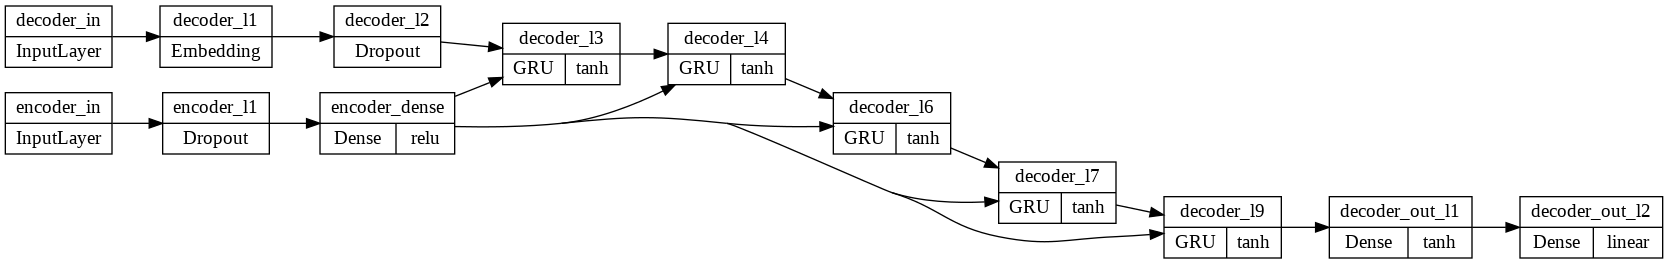

In [ ]:
# initialize encoder input and dense layers
encoder_in = Input(shape=(encoder_dim,), name='encoder_in')
encoder_l1 = Dropout(dropout_size, name='encoder_l1')(encoder_in)
encoder_l2 = Dense(hidden_units, activation='relu', name='encoder_dense')(encoder_l1)

# initialize decoder input, embedding and core layers
decoder_in = Input(shape=(None,), name='decoder_in')
decoder_l1 = Embedding(input_dim=vocab_len, output_dim=embedding_dim, name='decoder_l1')(decoder_in)
decoder_l2 = Dropout(dropout_size, name='decoder_l2')(decoder_l1)
decoder_l3 = GRU(hidden_units, return_sequences=True, name='decoder_l3')(decoder_l2, initial_state=encoder_l2)
decoder_l4 = GRU(hidden_units, return_sequences=True, name='decoder_l4')(decoder_l3, initial_state=encoder_l2)
#decoder_l5 = Dropout(dropout_size, name='decoder_l5')(decoder_l4)
decoder_l6 = GRU(hidden_units, return_sequences=True, name='decoder_l6')(decoder_l4, initial_state=encoder_l2)
decoder_l7 = GRU(hidden_units, return_sequences=True, name='decoder_l7')(decoder_l6, initial_state=encoder_l2)
#decoder_l8 = Dropout(dropout_size, name='decoder_l8')(decoder_l7)
decoder_l9 = GRU(hidden_units, return_sequences=True, name='decoder_l9')(decoder_l7, initial_state=encoder_l2)

# initialize decoder output layers
decoder_out_l1 = Dense(embedding_dim, activation='tanh', name='decoder_out_l1')(decoder_l9)
decoder_out_l2 = Dense(vocab_len, activation='linear', name='decoder_out_l2')(decoder_out_l1)

# build model and show summary
model = Model(inputs=[encoder_in, decoder_in], outputs=decoder_out_l2)
model.summary()

plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='LR', show_layer_activations=True)

In [ ]:
# sparse cross entropy loss function
# https://androidkt.com/image-captioning-using-tensorflow-high-level-api/?fbclid=IwAR0SMjYSUsTZ-_1tZMR1rPsLYk82xaVQTLTo8sHVMKiSg32Zx_fs7EB-nRs
def sparse_cross_entropy(y, y_hat):
    return reduce_mean(sparse_softmax_cross_entropy_with_logits(labels=y, logits=y_hat))

# initialize reduce learning rate on plateau and early stopping callbacks
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=rlr_patience),
             EarlyStopping(monitor='val_loss', patience=es_patience)]

# compile model with sparse cross entropy, adam, and sparse categorical accuracy
model.compile(loss=sparse_cross_entropy,
              optimizer=Adam(learning_rate=learning_rate),
              metrics=SparseCategoricalAccuracy())

# fit compiled model on data
history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=callbacks)

# save trained model as HDF5
model.save(model_name)

Epoch 1/20
506/506 [==============================] - 37s 57ms/step - loss: 2.0862 - sparse_categorical_accuracy: 0.6691 - val_loss: 1.5900 - val_sparse_categorical_accuracy: 0.7161 - lr: 0.0010
Epoch 2/20
506/506 [==============================] - 28s 56ms/step - loss: 1.4573 - sparse_categorical_accuracy: 0.7282 - val_loss: 1.3857 - val_sparse_categorical_accuracy: 0.7357 - lr: 0.0010
Epoch 3/20
506/506 [==============================] - 29s 56ms/step - loss: 1.2962 - sparse_categorical_accuracy: 0.7440 - val_loss: 1.3041 - val_sparse_categorical_accuracy: 0.7442 - lr: 0.0010
Epoch 4/20
506/506 [==============================] - 29s 57ms/step - loss: 1.2017 - sparse_categorical_accuracy: 0.7522 - val_loss: 1.2560 - val_sparse_categorical_accuracy: 0.7491 - lr: 0.0010
Epoch 5/20
506/506 [==============================] - 29s 57ms/step - loss: 1.1340 - sparse_categorical_accuracy: 0.7584 - val_loss: 1.2330 - val_sparse_categorical_accuracy: 0.7510 - lr: 0.0010
Epoch 6/20
506/506 [=====

In [ ]:
# load trained model
model = load_model(model_name, custom_objects={'sparse_cross_entropy': sparse_cross_entropy})

4. Model Training
 - The model is trained for at least 20 epochs and the loss and accuracy are plotted using the history variable.
 - The test performance is also calculated. 

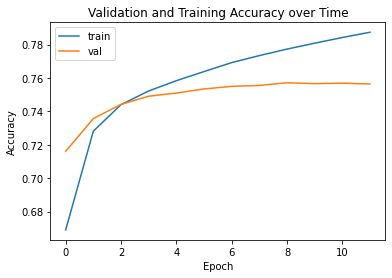

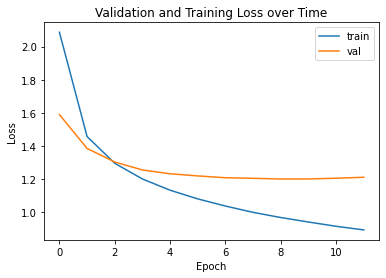

In [ ]:
# https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy

# plot for validation and training accuracy over time
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('Validation and Training Accuracy over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# plot for validation and training loss over time
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Validation and Training Loss over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

5. Evaluation
 - Images from outside the dataset are used to generate captions.

In [ ]:
# display image and caption
def display_caption(file_name, caption):

    # show image
    plt.imshow(plt.imread(file_name))
    plt.show()

    # convert tokenized caption to words, remove <end> token, capitalize first letter
    print('OUTPUT: ', " ".join(caption.numpy().astype('str')[:-1]).capitalize())

# generate caption
def caption_image(file_name, max_tokens=30):
    
    caption = []

    # preprocess image into vector
    img_vector = np.expand_dims(np.squeeze(model_pretrained.predict(preprocess_input(expand_dims(Resizing(286, 286)(io.decode_jpeg(io.read_file(file_name), channels=3)), axis = 0)))), axis=0)

    # initialize caption vector array and add <start> index to start of list 
    cap_vector = np.zeros(shape=(1, max_tokens), dtype=int)
    cap_vector[0, 0] = word_indexing(['<start>'])

    for i in range(max_tokens - 1):
        # predict next word and append to caption
        caption.append(np.argmax(model.predict({'encoder_in':img_vector ,'decoder_in': cap_vector})[0, i, :]))
        # update caption vector array with last prediction
        cap_vector[0, i+1] = caption[-1] 
        # if <end> token is predicted, stop generating sentence
        if cap_vector[0, i+1] == word_indexing(['<end>']):
            break

    # return caption
    return index_wording(caption)


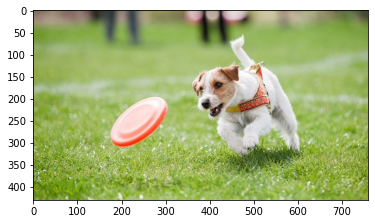

OUTPUT:  A white dog is running on a green plastic lawn




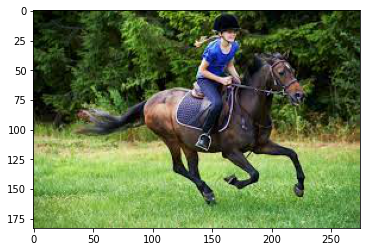

OUTPUT:  A horse rider is pulling a horse




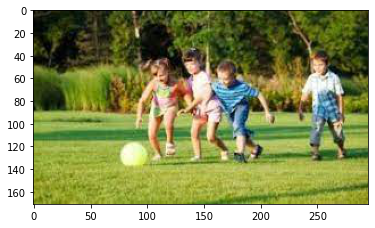

OUTPUT:  Two children playing soccer




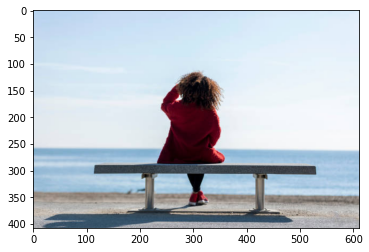

OUTPUT:  A little girl is sitting on a bench on a beach




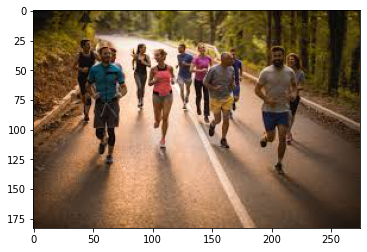

OUTPUT:  A group of people walking down a road




In [ ]:
# image source 1: https://www.istockphoto.com/se/foto/small-dog-playing-with-disk-gm483147984-70466279
# image source 2: https://www.gettyimages.com/search/stack/632234493?assettype=image&family=creative
# image source 3: https://www.shutterstock.com/image-photo/kids-playing-ball-59131981
# image source 4: https://depositphotos.com/209602824/stock-photo-handsome-smiling-african-american-man.html
# image source 5: https://www.gettyimages.com/detail/photo/full-length-of-marathon-runners-having-a-race-royalty-free-image/1061713622?

gen_image_paths = ['dog1.jpg', 'horse1.jpg', 'kid1.jpg', 'woman1.jpg', 'people1.jpg']

for gen_path in gen_image_paths:
    display_caption(gen_path, caption_image(gen_path, max_sent_len))
    print('\n')